<a href="https://colab.research.google.com/github/kevinsu-rgb/Senior_Design_TI_Project/blob/main/ticnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split


%matplotlib inline

In [222]:
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [223]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [224]:
def decode_heatmap_csv(filepath):
    df = pd.read_csv(filepath, header=None)
    numpy_array = df.values
    tensor = torch.from_numpy(numpy_array).float()
    tensor = tensor.unsqueeze(0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)
    return tensor


class HeatmapDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = []
        self.num_classes = 0

        for label_name in sorted(os.listdir(root_dir)):
            if label_name == '.ipynb_checkpoints':
                continue

            label_dir_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_dir_path):
                if label_name not in self.class_to_idx:
                    self.class_to_idx[label_name] = self.num_classes
                    self.idx_to_class.append(label_name)
                    self.num_classes += 1

                label_idx = self.class_to_idx[label_name]
                for heatmap_filename in os.listdir(label_dir_path):
                    if heatmap_filename.endswith('.csv'):
                        heatmap_filepath = os.path.join(label_dir_path, heatmap_filename)
                        self.samples.append((heatmap_filepath, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        heatmap_path, label = self.samples[idx]

        image = decode_heatmap_csv(heatmap_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [225]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_classes=2):
      super().__init__()
      self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

      self.classifiers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 8, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

  def forward(self, x):
      x = self.features(x)
      logits = self.classifiers(x)
      return logits

In [226]:
root_directory = 'data'
heatmap_dataset = HeatmapDataset(root_directory)

train_size = int(0.8 * len(heatmap_dataset))
test_size = len(heatmap_dataset) - train_size

train_dataset, test_dataset = random_split(heatmap_dataset, [train_size, test_size])

batch_size = 20

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"number of samples: {len(heatmap_dataset)}")
print(f"classes: {heatmap_dataset.class_to_idx}")

print(f"number of training batches: {len(train_dataloader)}")
print(f"number of testing batches: {len(test_dataloader)}")

number of samples: 195
classes: {'SITTING': 0, 'STANDING': 1}
number of training batches: 8
number of testing batches: 2


In [227]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_samples = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        total_samples += X.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

In [228]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item() * X.size(0)
            total_samples += X.size(0)

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples

    return avg_loss, accuracy

In [229]:
epochs = 10
train_losses = []
test_losses = []
test_accuracies = []

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for t in range(epochs):
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    print(f'[{t + 1}], loss: {avg_train_loss}')
print("Done!")

[1], loss: 0.6810506261312045
[2], loss: 0.6706505448390276
[3], loss: 0.581454200622363
[4], loss: 0.4649086319483243
[5], loss: 0.3242173149035527
[6], loss: 0.1858248668603408
[7], loss: 0.0664277433966979
[8], loss: 0.04761595212114163
[9], loss: 0.02367876833065962
[10], loss: 0.016844713129103184
Done!


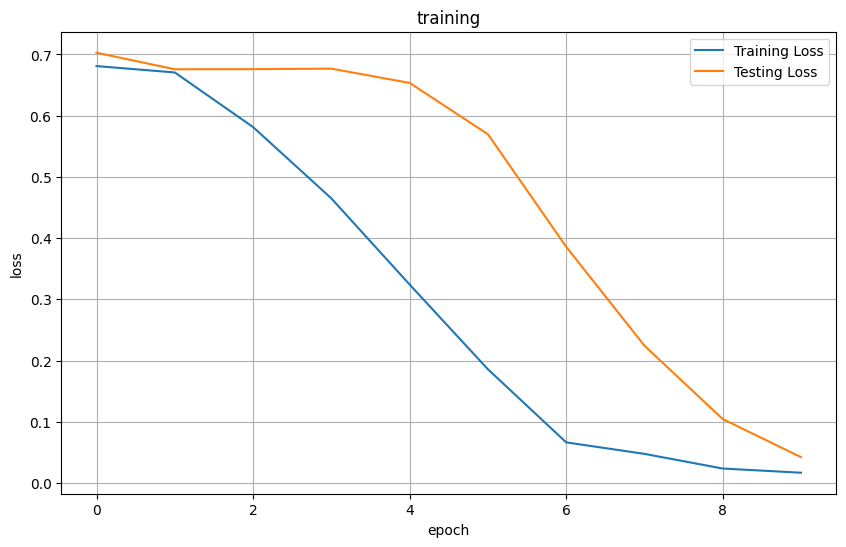

In [230]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training')
plt.legend()
plt.grid(True)
plt.show()

In [231]:
# save the model
torch.save(model.state_dict(), "model.pth")